<a href="https://colab.research.google.com/github/dev-SARDAR/FMML_Assignment-2022/blob/main/Module9_Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
# This is formatted as code
```

# Module 9: Convolutional Neural Networks Project(b)

## Module coordinator: Kushagra Agarwal



<img src="https://hub.packtpub.com/wp-content/uploads/2018/04/iStock-851960058-696x464.jpg" width=850px/>

In this project, you will understand how you can perform emotion recognition using CNNs in a step-by-step manner. To make your task easier, we provide you the starter code for the project. It is expected that you should try to understand the project statement properly and perform the tasks in sequence. We will be using Pytorch framework for the implementation. You need to fill in the missing code parts to achieve a particular task. At the end, you will have a basic implementation ready for an emotion detection application.

Basic steps involved in Emotion Recognition:
- Face detection
- Building classifier
- Classifying emotions

We will use a popular FER2013 dataset for this project. 

## Task 1: Explore the dataset
The dataset contains 48 x 48 grayscale facial images of faces.The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image. The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).

<img src="https://www.researchgate.net/profile/Chaudhary-Aqdus/publication/349055345/figure/fig3/AS:987834383085568@1612529478973/FER-2013-sample-images-for-facial-emotion-recognition.jpg" width=650px/>

Import libraries

In [1]:
# We have imported the necessary packages here. Feel free to import anything more you need!
import torch
import torchvision
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dlib
import cv2
from PIL import Image

### Download and load dataset

In [2]:
!gdown https://drive.google.com/uc?id=1YrNrok2Z1udWWIpejXIdLk7duUq87s0N
!unzip fer2013.csv.zip

Downloading...
From: https://drive.google.com/uc?id=1YrNrok2Z1udWWIpejXIdLk7duUq87s0N
To: /content/fer2013.csv.zip
100% 101M/101M [00:01<00:00, 64.1MB/s] 
Archive:  fer2013.csv.zip
  inflating: fer2013.csv             


In [3]:
# Load the dataset csv using pandas package. It displays the data in tabular form
emotion_data = pd.read_csv('./fer2013.csv')
print(emotion_data)

       emotion                                             pixels        Usage
0            0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...     Training
1            0  151 150 147 155 148 133 111 140 170 174 182 15...     Training
2            2  231 212 156 164 174 138 161 173 182 200 106 38...     Training
3            4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...     Training
4            6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...     Training
...        ...                                                ...          ...
35882        6  50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...  PrivateTest
35883        3  178 174 172 173 181 188 191 194 196 199 200 20...  PrivateTest
35884        0  17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...  PrivateTest
35885        3  30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...  PrivateTest
35886        2  19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...  PrivateTest

[35887 rows x 3 columns]


In [4]:
# Class dictionary for dataset
classes = {0:"Angry", 1:"Disgust", 2:"Fear", 3:"Happy", 4:"Sad", 5:"Surprise", 6:"Neutral"}

### Visualize a few images from dataset

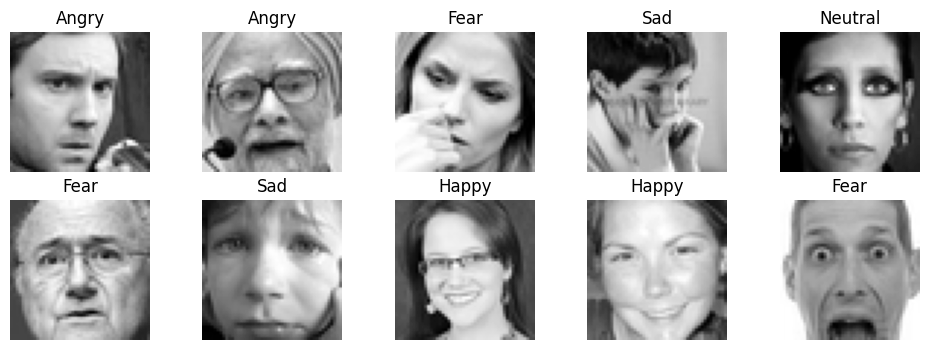

In [5]:
fig = plt.figure(figsize=(12,4))
for i in range(10):
  ax = plt.subplot(2,5,i+1)
  # This is how we access ith row in 'pixels' column in the dataset table
  img = emotion_data.iloc[i]['pixels'].split(' ') # Converting into array of ints 
  img = np.array(img).astype(int)

  # Labels for our dataset
  label = int(emotion_data.iloc[i]['emotion'])
  ax.imshow(img.reshape((48,48)), cmap='gray')
  ax.set_title(classes[label])
  ax.set_axis_off()
plt.show()

In [6]:
names, counts = np.unique(emotion_data['Usage'].to_numpy(), return_counts=True)
print('Number of samples in {} = {}'.format(names[0], counts[0])) #testset
print('Number of samples in {} = {}'.format(names[1], counts[1])) #valset
print('Number of samples in {} = {}'.format(names[2], counts[2])) #trainset

Number of samples in PrivateTest = 3589
Number of samples in PublicTest = 3589
Number of samples in Training = 28709


In [7]:
img_tensor = torch.from_numpy(img)
img = torch.cat((img_tensor, img_tensor, img_tensor), dim=0)

In [8]:
print(img.shape)

torch.Size([6912])


### Distribution of class labels

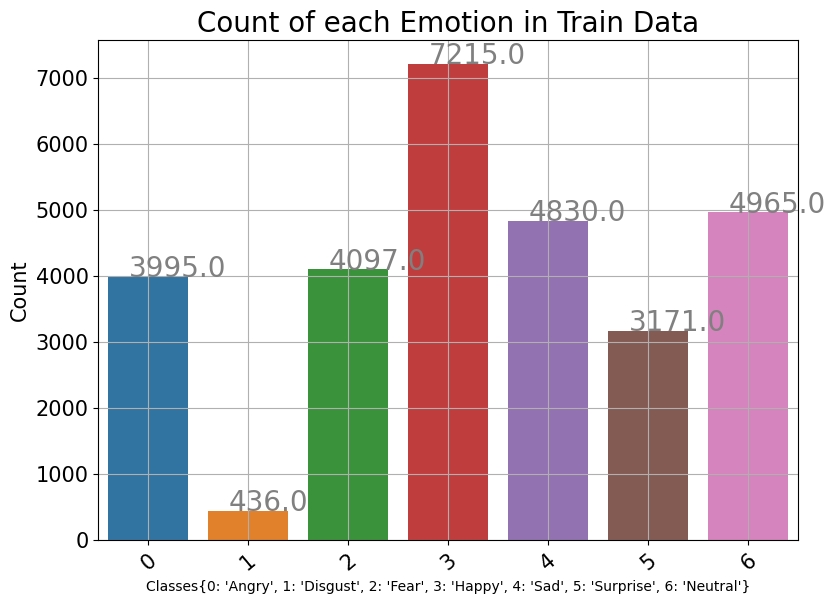

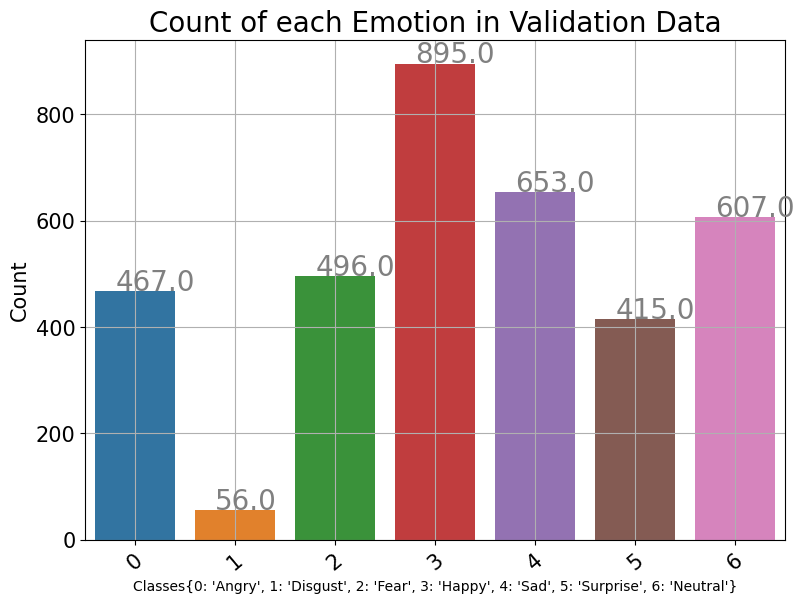

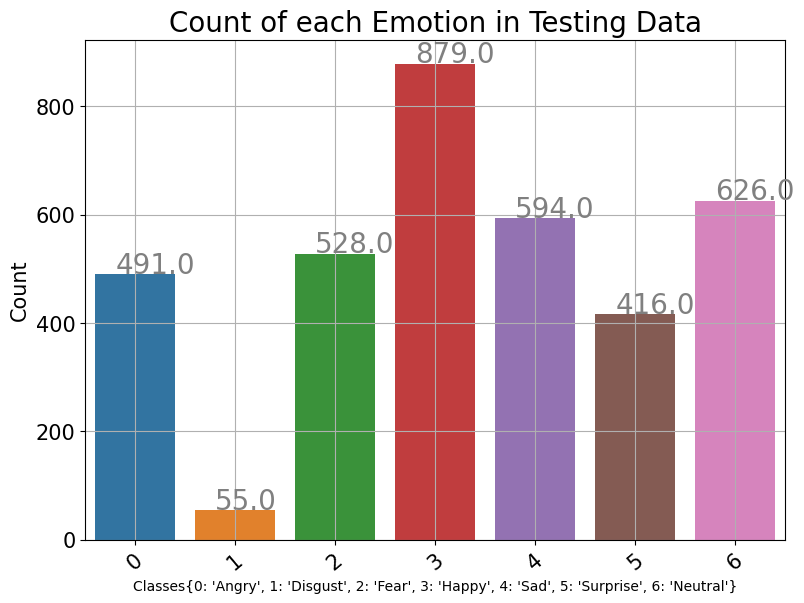

In [9]:
# Plot bar chart showing number of samples per class in the train set
temp_train = emotion_data.loc[emotion_data['Usage'] == 'Training']
df_temp_train = temp_train.sort_values(by = "emotion", inplace = False)
fig = plt.figure(figsize = (7, 5))
ax = fig.add_axes([0,0,1,1])
ax.set_title("Count of each Emotion in Train Data", fontsize = 20)
sns.countplot(x = "emotion", data = df_temp_train)
plt.grid()
for i in ax.patches:
    ax.text(x = i.get_x() + 0.2, y = i.get_height()+1.5, s = str(i.get_height()), fontsize = 20, color = "grey")
plt.xlabel("Classes"+ str(classes))
plt.ylabel("Count", fontsize = 15)
plt.tick_params(labelsize = 15)
plt.xticks(rotation = 40)
plt.show()

#VALIDATION
temp_val = emotion_data.loc[emotion_data['Usage'] == 'PublicTest']
df_temp_val = temp_val.sort_values(by = "emotion", inplace = False)
fig = plt.figure(figsize = (7, 5))
ax = fig.add_axes([0,0,1,1])
ax.set_title("Count of each Emotion in Validation Data", fontsize = 20)
sns.countplot(x = "emotion", data = df_temp_val)
plt.grid()
for i in ax.patches:
    ax.text(x = i.get_x() + 0.2, y = i.get_height()+1.5, s = str(i.get_height()), fontsize = 20, color = "grey")
plt.xlabel("Classes"+ str(classes))
plt.ylabel("Count", fontsize = 15)
plt.tick_params(labelsize = 15)
plt.xticks(rotation = 40)
plt.show()

#TESTING
temp_test = emotion_data.loc[emotion_data['Usage'] == 'PrivateTest']
df_temp_test = temp_test.sort_values(by = "emotion", inplace = False)
fig = plt.figure(figsize = (7, 5))
ax = fig.add_axes([0,0,1,1])
ax.set_title("Count of each Emotion in Testing Data", fontsize = 20)
sns.countplot(x = "emotion", data = df_temp_test)
plt.grid()
for i in ax.patches:
    ax.text(x = i.get_x() + 0.2, y = i.get_height()+1.5, s = str(i.get_height()), fontsize = 20, color = "grey")
plt.xlabel("Classes"+ str(classes))
plt.ylabel("Count", fontsize = 15)
plt.tick_params(labelsize = 15)
plt.xticks(rotation = 40)
plt.show()

Note the imbalance in the data through above graphs.

Face detection: Many applications involving facial images as input data require face detection in the pipeline at this step. Here, we localise the face in the given image removing the irrelevant parts, making the face centered and occupying most of the part in the image. As mentioned earlier, our dataset already has more or less centered faces, so we will skip this step for now but when using some other dataset or using your own images (eg. from webcam) as you will do later, you can do this step to get a proper cropped face from the image.

## Task 2: Data preprocessing

### Creating train, validation and test sets

In [10]:
X_train, y_train = [], []
X_val, y_val = [], []
X_test, y_test = [], []

for index, row in emotion_data.iterrows():
  k = row['pixels'].split(" ")

  if row['Usage'] == 'Training':
    X_train.append(np.array(k))
    y_train.append(row['emotion'])



for index, row in emotion_data.iterrows():
  h = row['pixels'].split(" ")

  if row['Usage'] == 'PublicTest':
    X_val.append(np.array(h))
    y_val.append(row['emotion'])

for index, row in emotion_data.iterrows():
  j = row['pixels'].split(" ")

  if row['Usage'] == 'PrivateTest':
    X_test.append(np.array(j))
    y_test.append(row['emotion'])


X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

print('Training set shape: ', X_train.shape, y_train.shape)
print('Validation set shape: ', X_val.shape, y_val.shape)
print('Testing set shape: ', X_test.shape, y_test.shape)

Training set shape:  (28709, 2304) (28709,)
Validation set shape:  (3589, 2304) (3589,)
Testing set shape:  (3589, 2304) (3589,)


In [11]:
# To get data between 0 and 1
X_train = X_train.astype(float) / 255.
X_test = X_test.astype(float) / 255.
X_val = X_val.astype(float) / 255.

We will define a dataset wrapper over Pytorch Dataset class which takes in the numpy arrays we created and returns a sample with required preprocessing.

In [12]:
class Fer2013Dataset(Dataset):
  def __init__(self, x, y, transforms=None):
    self.x = x.reshape((-1, 48, 48))
    self.y = y
    self.transforms= transforms

  def __getitem__(self, index):
    img, y = self.x[index], self.y[index]

    if self.transforms is not None:
        img = self.transforms(img)
    return img, y

  def __len__(self):
    return len(self.y)

In [13]:
batch_size=32

transform = transforms.ToTensor()

# Create tensor dataset from above tensors
train_dataset = Fer2013Dataset(X_train, y_train, transforms=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=2)

val_dataset = Fer2013Dataset(X_val, y_val, transforms=transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2)

test_dataset = Fer2013Dataset(X_test, y_test, transforms=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=2)

## Task 3: Building a CNN model

In [14]:
# Define your CNN architecture here
# To start with, let's say you can create a model with 4 relu-activated convs, 
# each followed by a pooling layer. Then, you can add 2-3 fully connected layers

#class Net(nn.Module):
 #   def __init__(self):
  #      super(Net,self).__init__()
        #### YOUR CODE HERE  ####
        
   # def forward(self,x):
        #### YOUR CODE HERE  ####
    #    return x



class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(64, 128, 3)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128, 512)
        self.relu5 = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)
        self.relu6 = nn.ReLU()
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.pool4(self.relu4(self.conv4(x)))
        x = x.view(x.size(0), -1)
        x = self.relu5(self.fc1(x))
        x = self.relu6(self.fc2(x))
        x = self.fc3(x)
        return x

num_classes = 7

model = Net(num_classes)


In [15]:
# Device (CPU/GPU)
#device = 'cpu' 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize the CNN
model = Net(num_classes).to(device)
print(model)
print(device)

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (relu4): ReLU()
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=128, out_features=512, bias=True)
  (relu5): ReLU()
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (relu6): ReLU()
  (fc3): Linear(in_features=256, out_features=7, bias=True)
)
cpu


### Training/Testing functions

In [16]:
def train(model, train_loader, loss_func, optimizer, num_epochs):

  # Training mode
  model.train()

  train_losses = []
  train_acc = []

  # Train the model
  for epoch in range(num_epochs):
    running_loss = 0
    running_acc = 0
    for i, (images, labels) in enumerate(train_loader):
      
      # clear gradients for this training step   
      optimizer.zero_grad()           

      # Forward pass
      output = model(images)

      # Calculate loss
      loss = loss_func(output, labels)

      # Backpropagation, compute gradients 
      loss.backward()

      # Apply gradients             
      optimizer.step()                
      
      # Running loss
      running_loss += loss.item()

      # indices of max probabilities
      _, preds = torch.max(output, dim=1)

      # Calculate number of correct predictions
      correct = (preds.float() == labels).sum()
      running_acc += correct

      # Average loss and acc values 
      epoch_loss = running_loss / len(train_loader.dataset)
      epoch_acc = running_acc / len(train_loader.dataset)

    train_losses.append(epoch_loss)
    train_acc.append(epoch_acc)
    print ('Epoch {}/{}, Loss: {:.4f}, Accuracy: {:.4f}'.format(epoch + 1, num_epochs, epoch_loss, epoch_acc*100))

  return train_losses, train_acc

In [17]:
 def test_model(model, testloader):
   correct = 0
   total = 0
  # Deactivate autograd engine (don't compute grads since we're not training)
   with torch.no_grad():
     for data in testloader:
         images, labels = data
        # Calculate outputs by running images through the network
         outputs = model(images)
        # The class with the highest value is what we choose as prediction
         _, predicted = torch.max(outputs.data, 1)
         total += labels.size(0)
         correct += (predicted == labels).sum().item()
   print('Accuracy of the network: %d %%' % (100 * correct / total))
   return total, correct

## Task 4: Training & Evaluation

### Train the model

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim

In [19]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

model = model.double()

# specify optimizer with learning rate
optimizer = optim.Adam(model.parameters(), lr=0.001)   # Pick an optimizer you think is suitable

history = train(model, train_loader, criterion, optimizer, num_epochs=10)

Epoch 1/10, Loss: 0.0539, Accuracy: 29.1198
Epoch 2/10, Loss: 0.0454, Accuracy: 43.0736
Epoch 3/10, Loss: 0.0412, Accuracy: 48.9359
Epoch 4/10, Loss: 0.0386, Accuracy: 52.7674
Epoch 5/10, Loss: 0.0364, Accuracy: 55.5854
Epoch 6/10, Loss: 0.0347, Accuracy: 57.9609
Epoch 7/10, Loss: 0.0332, Accuracy: 59.8523
Epoch 8/10, Loss: 0.0316, Accuracy: 61.5870
Epoch 9/10, Loss: 0.0304, Accuracy: 63.2833
Epoch 10/10, Loss: 0.0292, Accuracy: 64.8438


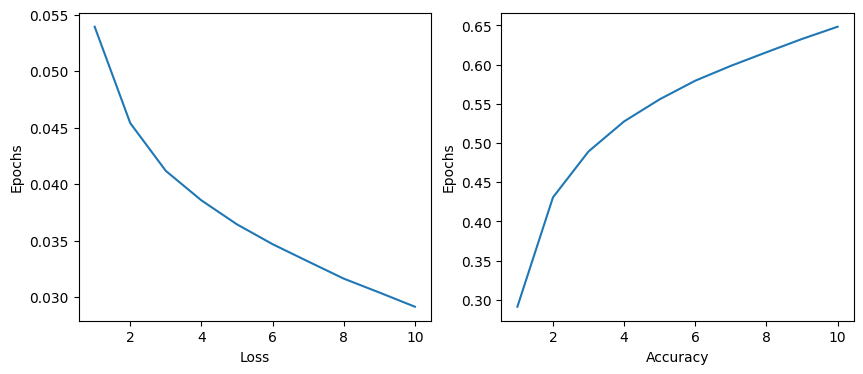

In [20]:
# You can fine-tune your model looking at below plots
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(np.arange(1,len(history[0])+1),history[0])
plt.xlabel('Loss')
plt.ylabel('Epochs')

ax = fig.add_subplot(1,2, 2)
ax.plot(np.arange(1,len(history[1])+1),history[1])
plt.xlabel('Accuracy')
plt.ylabel('Epochs')
plt.show()

### Evaluate your model

In [21]:
# Visualize top K predictions
def visualize_prediction(image, model, k=3):
  model.eval()

  preds = model(image.unsqueeze(1).float())

  topk = torch.topk(preds, k, dim=1)
  topk = topk.indices.numpy()
  print('Top {} Predictions'.format(k))
  for i in range(3):
    print('{}) {}'.format(i+1, classes[topk[0][i]]))

  plt.imshow(image[0].numpy(), cmap='gray')
  plt.show()

Top 3 Predictions
1) Disgust
2) Neutral
3) Surprise


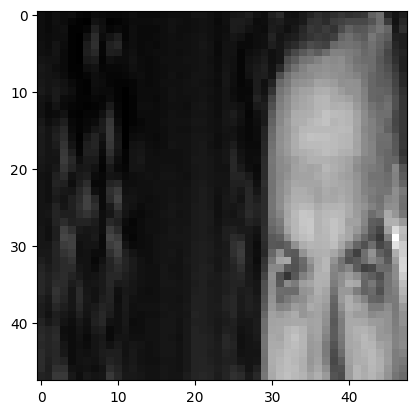


True label:  Surprise


In [22]:
image, label = test_dataset[1]
visualize_prediction(image, Net(num_classes))
print('\nTrue label: ', classes[int(label)])

In [23]:
# Print accuracy on test data
true_labels, predicted_labels = test_model(model, test_loader)

Accuracy of the network: 50 %


---

# BONUS TASK

### How can you improve the performance of your model given that the number of datapoints is fixed? 

##### Hint: A very simple fix (discussed in Lab 2) is to use a pretrained CNN model. The pretrained model could be trained on any dataset (eg Imagenet) and the first few layers of the same can be directly used for this task.

###Q) You are encouraged to try out different pretrained models like ResNet/VGG/AlexNet and see how the performance improves. Do all the models result in similar accuracy?

###Answer)

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

In [25]:
# Define the dataset class
class Fer2013Dataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x.reshape((-1, 48, 48)).astype(float)
        self.y = y
        self.transform = transform
    
    def __getitem__(self, index):
        img, y = self.x[index], self.y[index]
        
        if self.transform is not None:
            img = self.transform(img)
        return img, y
    
    def __len__(self):
        return len(self.y)

In [26]:
# Define the transforms
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [27]:
# Load the data
train_dataset = Fer2013Dataset(X_train, y_train, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)

test_dataset = Fer2013Dataset(X_test, y_test, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [28]:
# Define the number of classes in your dataset
num_classes = 7

In [29]:
# Load the pretrained ResNet model
resnet_model = models.resnet50(pretrained=True)
resnet_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, num_classes)

# Load the pretrained VGG model
#vgg_model = models.vgg16(pretrained=True)
#vgg_model.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
#vgg_model.classifier[6] = nn.Linear(vgg_model.classifier[6].in_features, num_classes)

# Load the pretrained AlexNet model
#alexnet_model = models.alexnet(pretrained=True)
#alexnet_model.features[0] = nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2)
#alexnet_model.classifier[6] = nn.Linear(alexnet_model.classifier[6].in_features, num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 295MB/s]


In [30]:
# Set the device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [31]:
# Transfer the models to the device
resnet_model = resnet_model.to(device)
#vgg_model = vgg_model.to(device)
#alexnet_model = alexnet_model.to(device)

In [32]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_resnet = optim.Adam(resnet_model.parameters(), lr=0.001)
#optimizer_vgg = optim.Adam(vgg_model.parameters(), lr=0.001)
#optimizer_alexnet = optim.Adam(alexnet_model.parameters(), lr=0.001)

In [33]:
# Training loop for ResNet
def train_resnet(model, train_loader, criterion, optimizer, num_epochs):
    model = model.double()
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        print('ResNet: Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, epoch_loss))

# Training loop for VGG
#def train_vgg(model, train_loader, criterion, optimizer, num_epochs):
#    model = model.double()
#    model.train()
#    for epoch in range(num_epochs):
#        running_loss = 0.0
#        for images, labels in train_loader:
#            images = images.to(device)
#            labels = labels.to(device)
            
#            optimizer.zero_grad()
            
#            outputs = model(images)
#            loss = criterion(outputs, labels)
            
#            loss.backward()
#            optimizer.step()
            
#            running_loss += loss.item() * images.size(0)
        
#        epoch_loss = running_loss / len(train_loader.dataset)
#        print('VGG: Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, epoch_loss))

# Training loop for AlexNet
#def train_alexnet(model, train_loader, criterion, optimizer, num_epochs):
#    model = model.double()
#    model.train()
#    for epoch in range(num_epochs):
#        running_loss = 0.0
#        for images, labels in train_loader:
#            images = images.to(device)
#            labels = labels.to(device)
            
#            optimizer.zero_grad()
            
#            outputs = model(images)
#            loss = criterion(outputs, labels)
            
#            loss.backward()
#            optimizer.step()
            
#            running_loss += loss.item() * images.size(0)
        
#        epoch_loss = running_loss / len(train_loader.dataset)
#        print('AlexNet: Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, epoch_loss))

In [34]:
# Training the models
num_epochs = 1

print("Training ResNet...")
train_resnet(resnet_model, train_loader, criterion, optimizer_resnet, num_epochs)

#print("Training VGG...")
#train_vgg(vgg_model, train_loader, criterion, optimizer_vgg, num_epochs)

#print("Training AlexNet...")
#train_alexnet(alexnet_model, train_loader, criterion, optimizer_alexnet, num_epochs)

Training ResNet...
ResNet: Epoch [1/1], Loss: 1.6571


In [35]:
# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

In [36]:
# Evaluate the models on test data
resnet_accuracy = evaluate_model(resnet_model, test_loader)
#vgg_accuracy = evaluate_model(vgg_model, test_loader)
#alexnet_accuracy = evaluate_model(alexnet_model, test_loader)

In [37]:
print('ResNet Accuracy on Test Data: {:.2f}%'.format(resnet_accuracy))
#print('VGG Accuracy on Test Data: {:.2f}%'.format(vgg_accuracy))
#print('AlexNet Accuracy on Test Data: {:.2f}%'.format(alexnet_accuracy))

ResNet Accuracy on Test Data: 41.71%


* Different pretrained models like ResNet, VGG, and AlexNet can result in different accuracies on the same task.
* The performance of a pretrained model depends on various factors such as the architecture, depth, number of parameters, and the dataset it was pretrained on.

* These models have different architectures and complexities, which can affect their ability to capture and generalize patterns in the data.
* Some models may have more layers or different types of layers, enabling them to learn more complex representations.
* Additionally, the pretrained models might have been trained on different datasets, which can impact their ability to transfer knowledge to a new task.

---

